# Prediction of Future User Adoption

## Introduction

The data is available as two attached CSV files: 'takehome_user_engagement.csv' and 'takehome_users.csv'.<br>
The data has the following two tables:<br><br>
<b>1-</b> A user table ("takehome_users") with data on 12,000 users who signed up for the product in the last two years. This table includes:<br>
<ul> 
<li><b>name:</b> the user's name</li>
<li> <b>object_id: </b>the user's id</li>
<li> <b>email:</b> email address</li>
<li> <b>creation_source:</b> how their account was created. This takes on one
of 5 values:
<ul>
<li>PERSONAL_PROJECTS: invited to join another user's personal workspace</li>
<li> GUEST_INVITE: invited to an organization as a guest (limited permissions)</li>
<li>ORG_INVITE: invited to an organization (as a full member)</li>
<li> SIGNUP: signed up via the website</li>
<li> SIGNUP_GOOGLE_AUTH: signed up using Google</li>
<li>Authentication (using a Google email account for their login
id)</li></ul>
<li> <b>creation_time:</b> when they created their account</li>
<li> <b>last_session_creation_time:</b> unix timestamp of last login</li>
<li><b> opted_in_to_mailing_list:</b> whether they have opted into receiving marketing emails</li>
<li> <b>enabled_for_marketing_drip:</b> whether they are on the regular marketing email drip</li>
<li> <b>org_id:</b> the organization (group of users) they belong to</li>
<li> <b>invited_by_user_id:</b> which user invited them to join (if applicable).</li></ul><br>
<b>2-</b> A usage summary table ("takehome_user_engagement") that has a row for each day that a user logged into the product.

## Objective

<ul><li>Define an "adopted user" as a user who has logged into the product on three separate days in at least one seven day period,</li><li>Identify which factors predict future user adoption.</li></ul>

In [1]:
# importing necessary packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

## Users Data

In [2]:
# reading the user table data, encoding it to 'latin-1', otherwise it fails to read the data
users = pd.read_csv('takehome_users.csv', encoding='latin-1')
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [3]:
# obtaining information about the data
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


There are missing values in last_session_creation_time, invited_by_user_id columns.There are also inconsistent data types. For example creation_time column values need to be in datetime format.

In [4]:
# changing the type of time columns to datetime
users.creation_time = pd.to_datetime(users['creation_time'])
users.last_session_creation_time = pd.to_datetime(users['last_session_creation_time'], unit='s')

## User Engagement Data

In [5]:
# reading the user engagement table data 
user_eng = pd.read_csv('takehome_user_engagement.csv')
user_eng.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [6]:
# obtaining information about the data
user_eng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [7]:
# changing the type of time columns to datetime
user_eng['time_stamp'] = pd.to_datetime(user_eng['time_stamp'])

## Determining Adopted Users

In [8]:
# determining number of visits by user in a week
visits = user_eng.groupby(['user_id', pd.Grouper(key='time_stamp', freq='W')])[['visited']].count()
# = user_eng['week/year'] = user_eng['time_stamp'].apply(lambda x: "%d/%d"% (x.week, x.year))
visits = visits.reset_index()

# getting weekly count max per user
max_visits = visits.groupby('user_id')['visited'].max()
max_visits = max_visits.reset_index()

# determining adopted users
max_visits['adopted'] = np.where(max_visits['visited'] >= 3, 1, 0)
max_visits.head()

,user_id,visited,adopted
0,1,1,0
1,2,3,1
2,3,1,0
3,4,1,0
4,5,1,0


## Data Wrangling

In [9]:
# merging two dataframes
users.rename({'object_id':'user_id'},inplace=True,axis=1)
df = pd.merge(users, max_visits, on='user_id',  how='outer')
# filling the NaN values in the adopted column with zeros since those users did not log into the product at all
df['adopted'] = df['adopted'].fillna(0)
df['visited'] = df['visited'].fillna(0)
df['last_session_creation_time'] = df['last_session_creation_time'].fillna(0)
df.tail()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,visited,adopted
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,2013-09-06 06:14:15,0,0,89,8263.0,1.0,0.0
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,2013-01-15 18:28:37,0,0,200,NaN,1.0,0.0
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,2014-04-27 12:45:16,1,1,83,8074.0,1.0,0.0
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,2012-06-02 11:55:59,0,0,6,NaN,1.0,0.0
11999,12000,2014-01-26 08:57:12,Lima Thaís,ThaisMeloLima@hotmail.com,SIGNUP,2014-01-26 08:57:12,0,1,0,NaN,1.0,0.0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 12 columns):
user_id                       12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    12000 non-null object
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
visited                       12000 non-null float64
adopted                       12000 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(4), object(4)
memory usage: 1.2+ MB


## Feature Engineering

'**creation_source**' column consists of five categories. I am appying pd.get_dummies method to convert categorical variable into dummy/indicator variables. pd.get_dummies creates a new dataframe which consists of zeros and ones. '**invited_by_user**' column is also categorical, but the categories are nominal meaning that they are only labeled without any order. I converted this column to zeros and ones by adding ones to the users who are invited by another user, otherwise zero. 

In [11]:
# making dummy variable for creation source column
data = pd.get_dummies(df, prefix=['cr_s'], columns=['creation_source'])

# creating a column showing if the user is invited by another user or not 
data['invited_by_user_id'] = np.where(df['invited_by_user_id'] > 0, 1, 0)

In the '**org_id**' column there are more than 400 categories. To be able to extract some imformation, I obtained the value counts of each company, then divided this number by all of the user to get a percentage that shows the importance of the company based on the number of users. 

In [12]:
# obtaining percentages that shows the frequency of a company
org_imp = df['org_id'].value_counts()/df['org_id'].value_counts().sum()
org_imp = dict(org_imp) # converting to a dictionary 
org_imp[0] = 0 # assuming that the org_id 0 represents no company
data['org_id'] = data['org_id'].map(org_imp) # mapping the dictionary to the org_id column of the dataframe

In [13]:
(df['org_id'].value_counts()/df['org_id'].value_counts().sum()).head(7)

0    0.026583
1    0.019417
2    0.016750
3    0.014000
4    0.013250
6    0.011500
5    0.010667
Name: org_id, dtype: float64

I used the '**time_stamp**' column to find the months and days where each user logged into the product most. Then dividing this number by the total number of logins I obtained the percentages that shows the importance of that month.

In [14]:
from datetime import datetime as dt

user_eng['month'] = user_eng['time_stamp'].dt.month
user_eng['day'] = user_eng['time_stamp'].dt.weekday_name
user_eng.head()

,time_stamp,user_id,visited,month,day
0,2014-04-22 03:53:30,1,1,4,Tuesday
1,2013-11-15 03:45:04,2,1,11,Friday
2,2013-11-29 03:45:04,2,1,11,Friday
3,2013-12-09 03:45:04,2,1,12,Monday
4,2013-12-25 03:45:04,2,1,12,Wednesday


In [15]:
month_visits = user_eng[['user_id', 'month', 'visited']]
month_visits = month_visits.groupby(['user_id', 'month']).sum()
month_visits = month_visits.reset_index()
month_visits.head()

,user_id,month,visited
0,1,4,1
1,2,1,1
2,2,2,5
3,2,3,3
4,2,11,2


In [16]:
idx = month_visits.groupby(['user_id'])['visited'].transform(max) == month_visits['visited']
monthly_max_visits = month_visits[idx]
monthly_max_visits.head()

,user_id,month,visited
0,1,4,1
2,2,2,5
6,3,3,1
7,4,5,1
8,5,1,1


In [17]:
max_months = month_visits[idx]['month'].value_counts()/month_visits[idx]['month'].value_counts().sum()
max_months = dict(max_months)
monthly_max_visits['month'] = monthly_max_visits['month'].map(max_months)
monthly_max_visits.head()

,user_id,month,visited
0,1,0.119248,1
2,2,0.072382,5
6,3,0.104943,1
7,4,0.183090,1
8,5,0.082951,1


In [18]:
# merging two dataframes
data = pd.merge(data, monthly_max_visits[['user_id','month']], on='user_id')

For the '**email**' column I obtained the most frequently used email domains.

In [19]:
data['domain'] = data['email'].str.split('@').str[1].str.split('.').str[0]

In [20]:
# obtaining percentages that shows the frequency of a company
dom_imp = data['domain'].value_counts()/data['domain'].value_counts().sum()
dom_imp = dict(dom_imp) # converting to a dictionary 
#org_imp[0] = 0 # assuming that the org_id 0 represents no company
data['domain'] = data['domain'].map(dom_imp)
data.head()

,user_id,creation_time,name,email,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,visited,adopted,cr_s_GUEST_INVITE,cr_s_ORG_INVITE,cr_s_PERSONAL_PROJECTS,cr_s_SIGNUP,cr_s_SIGNUP_GOOGLE_AUTH,month,domain
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,2014-04-22 03:53:30,1,0,0.006250,1,1.0,0.0,1,0,0,0,0,0.119248,0.194619
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,2014-03-31 03:45:04,0,0,0.019417,1,3.0,1.0,0,1,0,0,0,0.072382,0.095121
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,2013-03-19 23:14:52,0,0,0.002667,1,1.0,0.0,0,1,0,0,0,0.104943,0.095121
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,2013-05-22 08:09:28,0,0,0.019417,1,1.0,0.0,1,0,0,0,0,0.183090,0.194619
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,2013-01-22 10:14:20,0,0,0.001333,1,1.0,0.0,1,0,0,0,0,0.082951,0.194619


## Exploratory Data Analysis

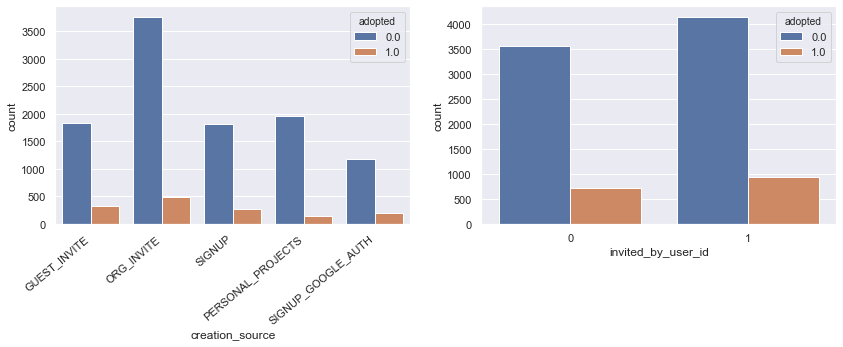

In [21]:
fig, axs = plt.subplots(ncols=2, figsize=(14,4))

# Creation source and adopted user
ax1 = sns.countplot(x='creation_source', data=df, hue='adopted', ax=axs[0])
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40, ha="right")
ax2= sns.countplot(x='invited_by_user_id', data=data, hue='adopted', ax=axs[1])

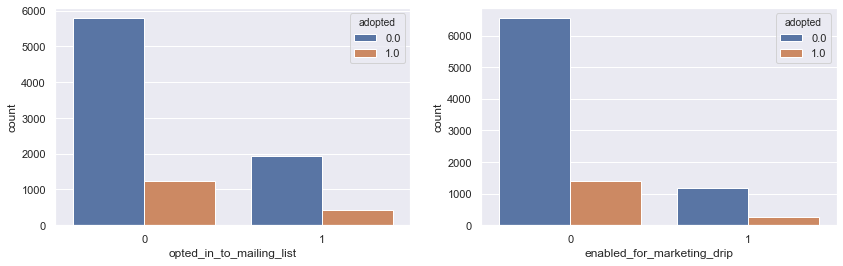

In [22]:
fig, axs = plt.subplots(ncols=2, figsize=(14,4))
ax3= sns.countplot(x='opted_in_to_mailing_list', data=data, hue='adopted', ax=axs[0])
ax4= sns.countplot(x='enabled_for_marketing_drip', data=data, hue='adopted', ax=axs[1])

### Up-sample Minority Class

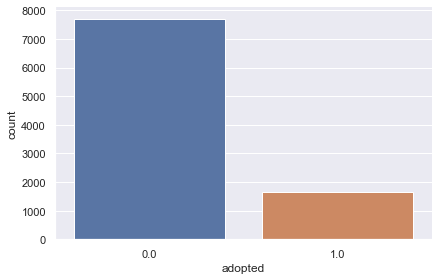

In [23]:
_ = sns.catplot(x='adopted', kind="count", data=data, height=4, aspect=1.5)

The number of adopted users is very small compared to the number of not adopted users. This might be a problem, because the classifier learns the classes with more samples better and remain weak on the smaller classes. So I increase the number of adoptedusers with upsampling method. In upsampling, for every observation in the majority class, we randomly select an observation from the minority class with replacement. The end result is the same number of observations from the minority and majority classes.

In [24]:
data.columns

Index(['user_id', 'creation_time', 'name', 'email',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id', 'visited',
       'adopted', 'cr_s_GUEST_INVITE', 'cr_s_ORG_INVITE',
       'cr_s_PERSONAL_PROJECTS', 'cr_s_SIGNUP', 'cr_s_SIGNUP_GOOGLE_AUTH',
       'month', 'domain'],
      dtype='object')

In [25]:
df_final = data[[ 'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id',
                 'adopted', 'month','domain', 'cr_s_ORG_INVITE', 'cr_s_PERSONAL_PROJECTS', 'cr_s_SIGNUP',
                 'cr_s_SIGNUP_GOOGLE_AUTH']]

# importing module for resampling
from sklearn.utils import resample

# Separate majority and minority classes
df_final_majority = df_final[df_final.adopted==0]
df_final_minority = df_final[df_final.adopted==1]
 
# Upsample minority class
df_final_minority_upsampled = resample(df_final_minority, 
                                 replace=True,                        # sample with replacement
                                 n_samples=len(df_final_majority),    # to match majority class
                                 random_state=123)                    # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_final_majority, df_final_minority_upsampled])
 
# Display new class counts
df_upsampled.adopted.value_counts()

1.0    7712
0.0    7712
Name: adopted, dtype: int64

## Model Prediction

In [26]:
df_upsampled.columns

Index(['opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id',
       'invited_by_user_id', 'adopted', 'month', 'domain', 'cr_s_ORG_INVITE',
       'cr_s_PERSONAL_PROJECTS', 'cr_s_SIGNUP', 'cr_s_SIGNUP_GOOGLE_AUTH'],
      dtype='object')

## Random Forest 

In [27]:
from sklearn.model_selection import train_test_split

#set up data by seperating out the labels, then split for cross validation
features = df_upsampled.drop('adopted', axis=1)
target = df_upsampled['adopted']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

In [28]:
from sklearn.ensemble import RandomForestClassifier

#train and test classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

print('Accuracy score on train set:', rf.score(X_train, y_train))
print('Accuracy score on test set:', rf.score(X_test, y_test))

Accuracy score on train set: 0.9548907002593553
Accuracy score on test set: 0.8722990492653414


In [29]:
# printing the classification report
print(classification_report(y_test, rf.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.94      0.79      0.86      2302
         1.0       0.82      0.95      0.88      2326

    accuracy                           0.87      4628
   macro avg       0.88      0.87      0.87      4628
weighted avg       0.88      0.87      0.87      4628



### Hyperparameter Tuning

In [30]:
from sklearn.model_selection import GridSearchCV
# Tune hyperparameters in decision tree classifier using GridSearchCV
# Setup the parameters and distributions to sample from: param_grid

param_grid = {"max_depth": [11, 13, 15],
              "max_features": [1,2,3,4],
              "min_samples_leaf": [0.1,1,2],
              "criterion": ["gini", "entropy"]}

# Instantiate the GridSearchCV object
grid_cv = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)

# Fit to training data
grid_cv.fit(X_train, y_train)   

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(grid_cv.best_params_))
print("Best CV score is {}".format(grid_cv.best_score_))

Tuned Decision Tree Parameters: {'criterion': 'gini', 'max_depth': 15, 'max_features': 4, 'min_samples_leaf': 1}
Best CV score is 0.8340125972582438


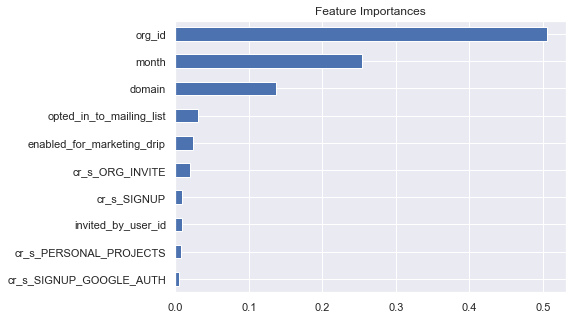

In [31]:
# Create series of the features importances and sort the values
importances = pd.Series(rf.feature_importances_, index=['opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id',
       'invited_by_user_id', 'month', 'domain','cr_s_ORG_INVITE',
       'cr_s_PERSONAL_PROJECTS', 'cr_s_SIGNUP', 'cr_s_SIGNUP_GOOGLE_AUTH']).sort_values()

# Visualize the ranked importance of the features in a horizontal bar plot
plt.figure(figsize=(7,5))
importances.plot(kind='barh')
plt.title('Feature Importances')
plt.show();

## XGBoost

In [32]:
from xgboost import XGBClassifier
xg = XGBClassifier()
xg.fit(X_train, y_train)

print('Accuracy score on train set:', xg.score(X_train, y_train))
print('Accuracy score on test set:', xg.score(X_test, y_test))

Accuracy score on train set: 0.6986846980363097
Accuracy score on test set: 0.7015989628349178


In [33]:
# printing the classification report
print(classification_report(y_test, xg.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.72      0.65      0.68      2302
         1.0       0.68      0.76      0.72      2326

    accuracy                           0.70      4628
   macro avg       0.70      0.70      0.70      4628
weighted avg       0.70      0.70      0.70      4628



### Hyperparameter Tuning

In [34]:
# Tune hyperparameters in decision tree classifier using GridSearchCV
# Setup the parameters and distributions to sample from: param_grid
import xgboost as xgb
param_grid_xgb= {"learning_rate": [ 0.5, 0.7, 1],
              "n_estimators": [100, 150, 200],
              "subsample": [0.5,0.9, 1]}
xgb_ = xgb.XGBClassifier(random_state=1)

# Instantiate the GridSearchCV object
grid_cv = GridSearchCV(estimator=xgb_, param_grid = param_grid_xgb, cv=4)

# Fit to training data
grid_cv.fit(X_train, y_train)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(grid_cv.best_params_))
print("Best CV score is {}".format(grid_cv.best_score_))

Tuned Decision Tree Parameters: {'learning_rate': 1, 'n_estimators': 200, 'subsample': 0.9}
Best CV score is 0.7222119303445721


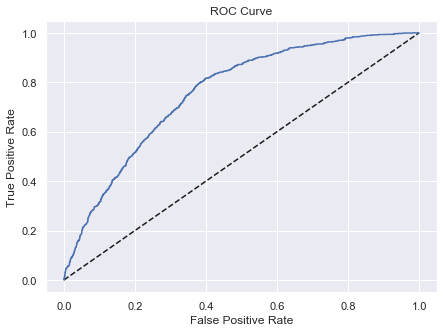

In [35]:
# Import necessary modules 
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Compute predicted probabilities: y_pred_prob
y_pred_prob = xg.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(7,5))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [36]:
# Compute and print AUC score
#print("Area under the ROC curve roc_auc_score(y_test, y_pred_prob))

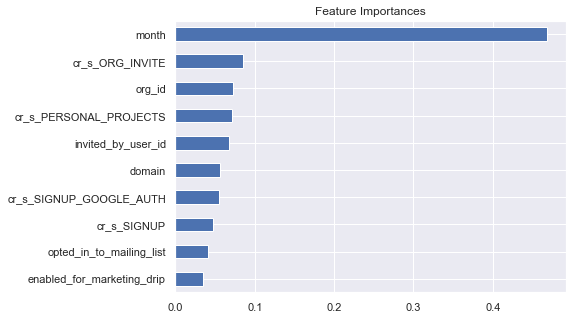

In [37]:
# Create series of the features importances and sort the values
importances = pd.Series(xg.feature_importances_, index=['opted_in_to_mailing_list', 'enabled_for_marketing_drip',
       'org_id', 'invited_by_user_id', 'month', 'domain', 'cr_s_ORG_INVITE',
       'cr_s_PERSONAL_PROJECTS', 'cr_s_SIGNUP', 'cr_s_SIGNUP_GOOGLE_AUTH']).sort_values()

# Visualize the ranked importance of the features in a horizontal bar plot
plt.figure(figsize=(7,5))
importances.plot(kind='barh')
plt.title('Feature Importances')
plt.show();

Random Forest classifier gives a higher score than XGBoost. Most important features that predict future user adoption using the Random Forest Classifier is organization id, month of the year and domain. XGBoost Classifier gives a lower accuracy. The most important features using this model are month, creation source( organization invitation) and organization id.